# 3. Solving inverse problems - 1D harmonic oscillator

This notebook shows you how to use FBPINNs to solve inverse problems.

> Note: before reading this notebook, make sure you have read example `1. Defining your own problem.ipynb` first.

# Problem overview

In this example, similar to `1. Defining your own problem.ipynb`, we will use a FBPINN to solve an inverse problem related to the 1D damped harmonic oscillator:

<img src="oscillator.gif" width="500">

The ordinary differential equation (ODE) is given by:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

# Solving an inverse problem

In `1. Defining your own problem.ipynb`, we only used the FBPINN to solve the ODE, i.e. solve the **forward problem**.

An **inverse problem** is where we instead want to **learn underlying parameters** of the ODE itself, given a set of (potentially noisy) **observations**, $\{u_{\mathrm{obs}}\}_{i=1}^M$, of the solution.

Solving inverse problems with (FB)PINNs is conceptually very simple; as well as learning the parameters of the (FB)PINN (i.e. learning the solution), we also treat the underlying parameters of the ODE as **learnable parameters**, and jointly optimise them.

### Solving an harmonic oscillator inverse problem

Consider the case where we have some observations, $\{u_{\mathrm{obs}}\}_{i=1}^M$, of the position of the oscillator through time, and we want to invert for the coefficient of friction, $\mu$, in the ODE.

In this case, the following **loss function** is used to train the (FB)PINN:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( N\!N(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

Here, the first term is the **physics loss**, which is the same as in the forward problem. The second term is called the **data loss**, and ensures that the learned solution fits the observational data.

Solving the inverse problem amounts to minimising this loss function, and once trained we can just read out the learned value of $\mu$.

# Workflow overview

We will use the following steps to solve this inverse problem with a FBPINN:

1. Define a trainable parameter and the loss function in the `Problem` class
2. Train the FBPINN using this `Problem` class

## Step 1: Define a trainable parameter and the loss function in the `Problem` class

First, we will define a new `Problem` class by inheriting from the `HarmonicOscillator1D` class defined in `1. Defining your own problem.ipynb`.

Then, we need to make two changes to this class:
1. Define $\mu$ as a trainable parameter instead of a static parameter in `Problem.init_params`. Then `fbpinns.trainers.FBPINNTrainer` will automatically optimise this parameter alongside the network parameters.
2. Rewrite the `Problem.sample_constraints` and `Problem.loss_fn` methods to evaluate the loss function above

Note, for this problem we assume we have 13 equally-spaced observational points of the exact solution without noise.

In [1]:
import jax.numpy as jnp
from fbpinns.problems import HarmonicOscillator1D

class HarmonicOscillator1DInverse(HarmonicOscillator1D):
    """Solves the time-dependent damped harmonic oscillator inverse problem
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        Boundary conditions:
        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20):

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1),
            "d":d,
            "w0":w0,
            "mu_true":mu,
            "k":k,
            }
        trainable_params = {
            "mu":jnp.array(0.),# learn mu from constraints
            }

        return static_params, trainable_params

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )

        # data loss
        x_batch_data = jnp.linspace(0,1,13).astype(float).reshape((13,1))# use 13 observational data points
        u_data = HarmonicOscillator1DInverse.exact_solution(all_params, x_batch_data)
        required_ujs_data = (
            (0,()),
            )

        return [[x_batch_phys, required_ujs_phys], [x_batch_data, u_data, required_ujs_data]]

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["trainable"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        # physics loss
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        # data loss
        _, uc, u = constraints[1]
        data = 1e6*jnp.mean((u-uc)**2)

        return phys + data

## Step 2: Train the FBPINN using this `Problem` class

Finally, we can train the `FBPINN` using this new `Problem` class:

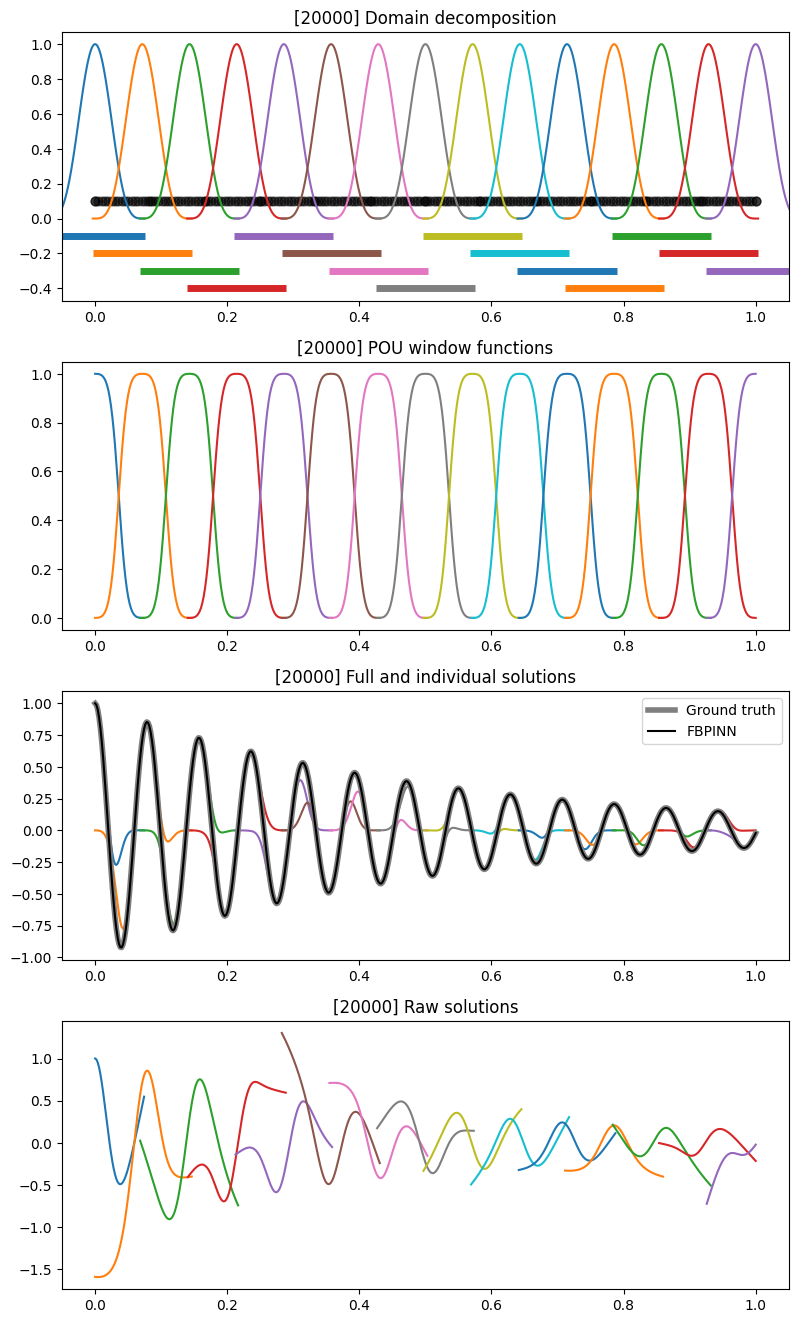

[INFO] 2023-07-30 17:08:32 - [i: 20000/20000] Training complete
{'mu': Array(4.0133853, dtype=float32)}


In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

c = Constants(
    domain=RectangularDomainND,# use a 1D problem domain [0, 1]
    domain_init_kwargs=dict(
        xmin=np.array([0,]),
        xmax=np.array([1,]),
    ),
    problem=HarmonicOscillator1DInverse,
    problem_init_kwargs=dict(
        d=2, w0=80,# define the ODE parameters
    ),
    decomposition=RectangularDecompositionND,# use a rectangular domain decomposition
    decomposition_init_kwargs=dict(
        subdomain_xs=[np.linspace(0,1,15)],# use 15 equally spaced subdomains
        subdomain_ws=[0.15*np.ones((15,))],# with widths of 0.15
        unnorm=(0.,1.),# define unnormalisation of the subdomain networks
    ),
    network=FCN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        layer_sizes=[1,32,1],# with 2 hidden layers
    ),
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=20000,# number of training steps
    clear_output=True,
)

run = FBPINNTrainer(c)
all_params = run.train()
print(all_params["trainable"]["problem"])# print out learned value of mu